In [4]:
import os
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF
import numpy as np
from tqdm import tqdm
import re

In [5]:
def rotate_images(image):
    # 이미지를 0도, 90도, 180도, 270도로 회전시키는 함수
    images = []
    for angle in [0, 90, 180, 270]:
        rotated_image = TF.rotate(image, angle)
        images.append(rotated_image)
    return images

def gauss_noise(image_tensor, sigma=0.05):
    # 이미지에 가우시안 노이즈를 추가하는 함수
    noise = torch.randn(image_tensor.size()) * sigma
    noisy_image = image_tensor + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image


class VAECustomDataset(Dataset):
    def __init__(self, file_paths, transform=None, gauss_sigma=0.05):
        # 데이터셋 초기화
        self.file_paths = file_paths
        self.transform = transform
        self.gauss_sigma = gauss_sigma

    def __len__(self):
        # 데이터셋의 길이를 반환
        return len(self.file_paths)

    def __getitem__(self, idx):
        # 주어진 인덱스에 해당하는 데이터를 반환
        image = Image.open(self.file_paths[idx])
        if self.transform:
            # 변환이 주어진 경우
            original_image = self.transform(image)  # 원본 이미지 변환
            noisy_image = gauss_noise(original_image, self.gauss_sigma)  # 노이즈 추가 이미지 생성
            images = rotate_images(image)  # 회전 이미지 생성
            transformed_images = [self.transform(img) for img in images]  # 회전 이미지를 변환
            noisy_images = [gauss_noise(img, self.gauss_sigma) for img in transformed_images]  # 회전된 이미지에 노이즈 추가
            return original_image, noisy_image, transformed_images, noisy_images
        else:
            # 변환이 주어지지 않은 경우 원본 이미지 반환
            return image


In [3]:
# 이미지 크기 설정
img_size = 480

# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # 이미지 크기 조정
    transforms.Grayscale(),  # 흑백 변환
    transforms.ToTensor(),  # 텐서로 변환
])

In [7]:
# 데이터 폴더 경로 설정
folder = r"D:\datacut\Good"
data_path = []
for filename in os.listdir(folder):
    # 폴더 내 파일 경로를 리스트에 추가
    data_path.append(os.path.join(folder, filename))

In [8]:
# 커스텀 데이터셋 생성
custom_dataset = VAECustomDataset(data_path, transform=transform)

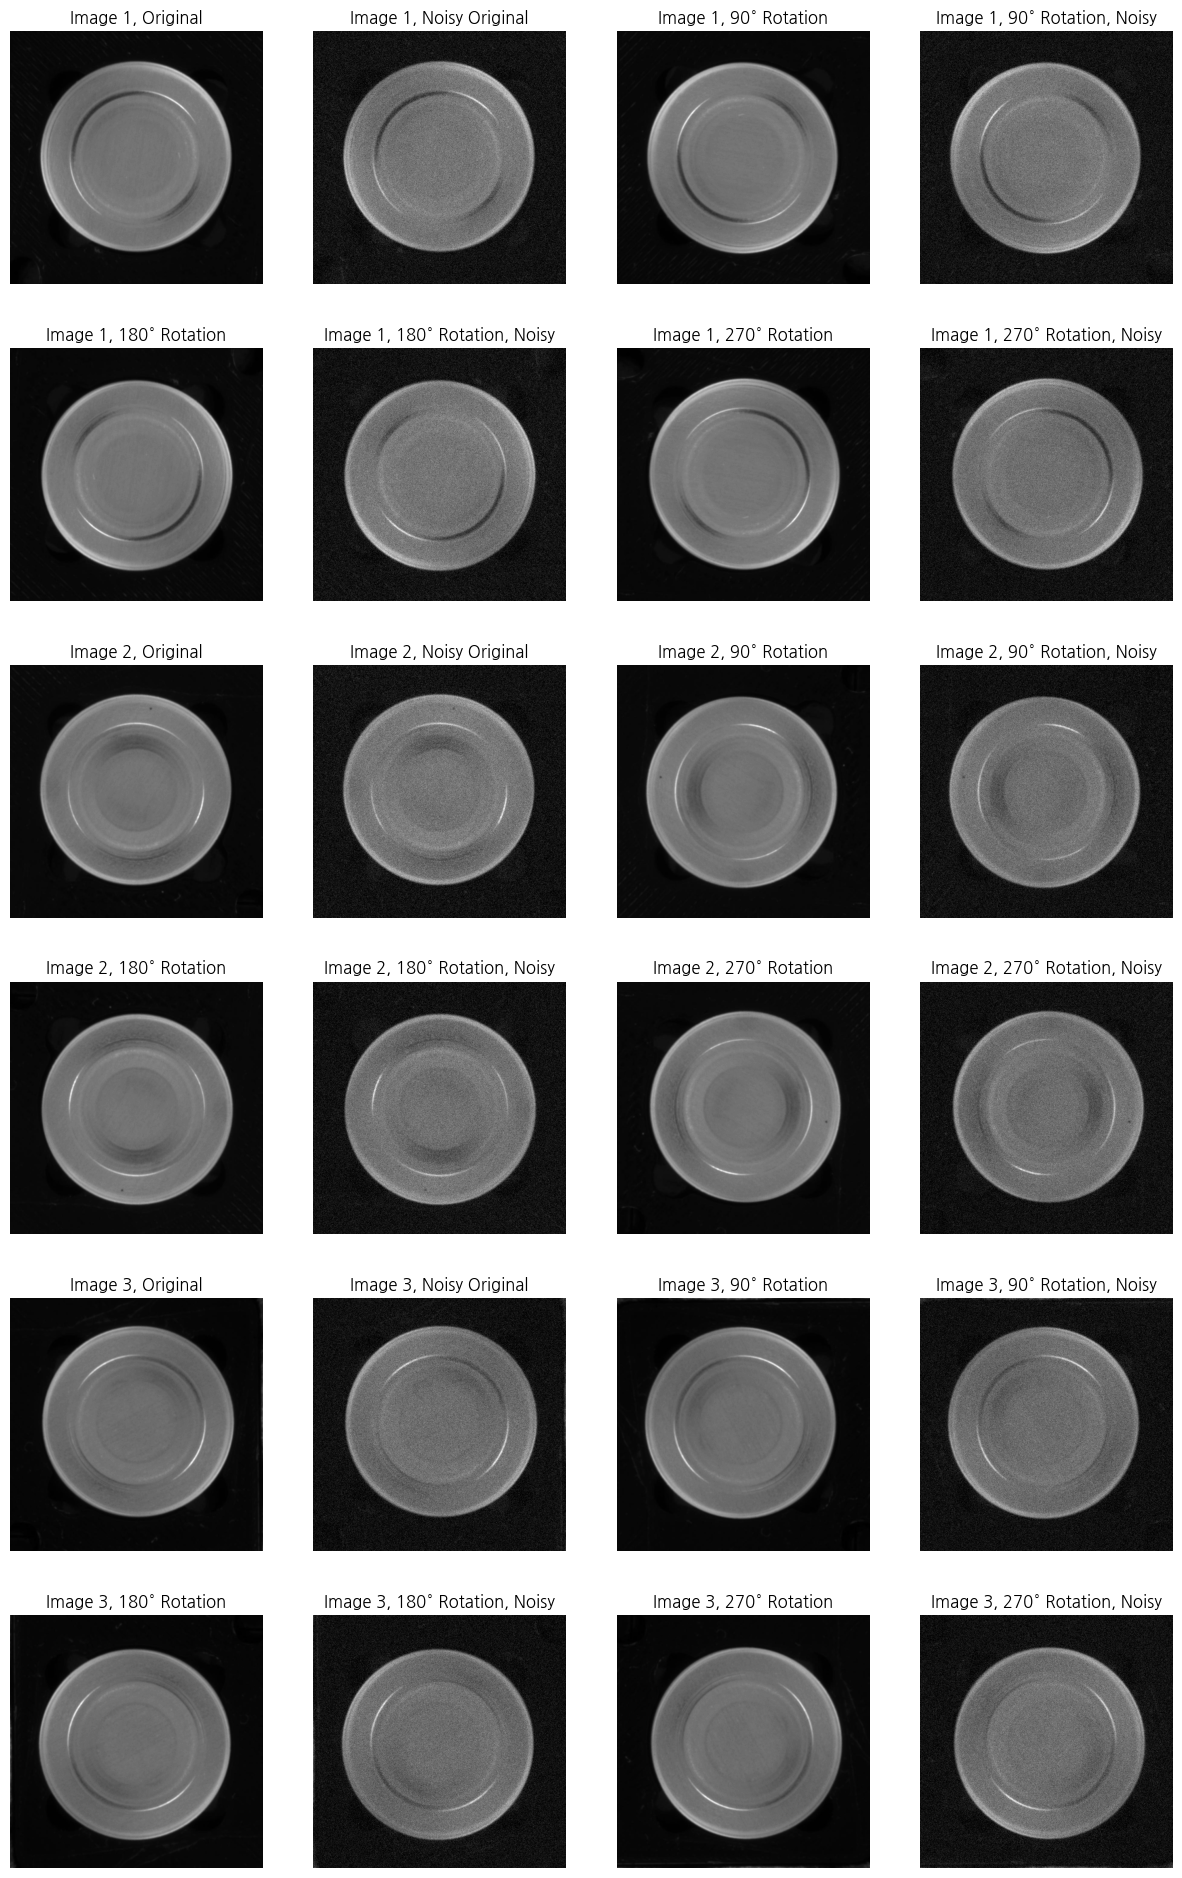

In [9]:
num_rows = 3 * 2
plt.figure(figsize=(15, num_rows * 4))
for i in range(3):
    original_image, noisy_image, transformed_images, noisy_images = custom_dataset[i]

    # Original Image
    plt.subplot(num_rows, 4, i * 8 + 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title(f'Image {i+1}, Original')
    plt.axis('off')

    # Noisy Original Image
    plt.subplot(num_rows, 4, i * 8 + 2)
    plt.imshow(noisy_image.squeeze(), cmap='gray')
    plt.title(f'Image {i+1}, Noisy Original')
    plt.axis('off')

    # Rotated Images
    for j in range(3):
        plt.subplot(num_rows, 4, i * 8 + 3 + j * 2)
        plt.imshow(transformed_images[j + 1].squeeze(), cmap='gray')
        plt.title(f'Image {i+1}, {90 * (j + 1)}° Rotation')
        plt.axis('off')

        plt.subplot(num_rows, 4, i * 8 + 4 + j * 2)
        plt.imshow(noisy_images[j + 1].squeeze(), cmap='gray')
        plt.title(f'Image {i+1}, {90 * (j + 1)}° Rotation, Noisy')
        plt.axis('off')

plt.show()